# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from transformers import BertConfig
from transformers import RobertaTokenizerFast

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Py

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
sequence_len = 512
batch_size = 64

config = BertConfig(
    vocab_size=9,
    hidden_size=84,
    num_hidden_layers=2,
    num_attention_heads=6,
    intermediate_size=64,
    max_position_embeddings=sequence_len,
    num_labels=2
)

epochs = 30

# Load & Prepare the data

In [4]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

# drop unreducable by LO or RI
print(f"number samples: {len(all_data)}")
all_data = all_data[[x_ != 1000 for x_ in all_data["RI_steps_num"]]].reset_index(drop=True)
all_data = all_data[[x_ != 1000 for x_ in all_data["LO_steps_num"]]].reset_index(drop=True)
print(f"number samples only reducable: {len(all_data)}\n")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_test = all_data["simple_terms"].tolist()
# RI has fewer steps -> 1
# Otherwise 0
y_test = [1 if los > ris else 0 for los, ris in zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]
y_ri_test = all_data["RI_steps_num"].tolist()
y_lo_test = all_data["LO_steps_num"].tolist()

print(f"Count TESTING samples: {len(y_test)}")

Count all terms: 4251

Count original terms: 4251

number samples: 4251
number samples only reducable: 4220

max RI steps count: 386
max LO steps count: 219
Count TESTING samples: 4220


In [5]:
all_data = pd.read_csv("../../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str_extended.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

# drop unreducable by LO or RI
print(f"number samples: {len(all_data)}")
all_data = all_data[[x_ != 1000 for x_ in all_data["RI_steps_num"]]].reset_index(drop=True)
all_data = all_data[[x_ != 1000 for x_ in all_data["LO_steps_num"]]].reset_index(drop=True)
print(f"number samples only reducable: {len(all_data)}\n")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_train = all_data["simple_terms"].tolist()
# RI has fewer steps -> 1
# Otherwise 0
y_train = [1 if los > ris else 0 for los, ris in zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]
y_ri_train = all_data["RI_steps_num"].tolist()
y_lo_train = all_data["LO_steps_num"].tolist()

print(f"Count TRAINING samples: {len(y_train)}")

Count all terms: 44568

Count original terms: 44568

number samples: 44568
number samples only reducable: 42469

max RI steps count: 400
max LO steps count: 308
Count TRAINING samples: 42469


In [6]:
tokenizer = RobertaTokenizerFast.from_pretrained("../../transformers_to_lo_steps_prediciton/fine_models", max_len=sequence_len)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
x_train = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_train]
x_test = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_test]

In [8]:
def get_sample_weight(arr_1, arr_2):
    arr_1, arr_2 = np.array(arr_1), np.array(arr_2)
    abs_diff = np.abs(arr_1 - arr_2)
    return abs_diff


train_df = pd.DataFrame({
    "term_str": x_train, "is_ri_best": y_train,
    "lo_steps": y_lo_train, "ri_steps": y_ri_train,

    "sample_weights": get_sample_weight(y_ri_train, y_lo_train),
})
test_df = pd.DataFrame({
    "term_str": x_test, "is_ri_best": y_test,
    "lo_steps": y_lo_test, "ri_steps": y_ri_test,
    "sample_weights": get_sample_weight(y_ri_test, y_lo_test),
})

In [9]:
train_df.head(10)

,term_str,is_ri_best,lo_steps,ri_steps,sample_weights
0,(y(y((x(y((x(y((x((x((xx)(y(((xx)(((yx)(x((yx)...,0,3,3,0
1,((((((((y(y(yx)))(y(yx)))(((yx)(y(y((x(y(y(y(y...,0,60,187,127
2,(y(y(x(((((y(yx))(yx))((y(y(yx)))(y(y(xx)))))(...,0,5,8,3
3,(y(((x((xx)(x(x(xx)))))((x((x(yx))(xx)))((y(x(...,1,7,4,3
4,(y((x(y((((x(x(y(y(x((xx)x))))))(x(((y(x((x((y...,0,2,2,0
5,(y(y(((((((x(x(y(yx))))(x(x(y(x(x(y(yx))))))))...,0,20,78,58
6,((y(y(y((y(y((yx)x)))(x(((yx)(yx))((((y(yx))(y...,0,3,8,5
7,((y((((y(xx))(y((yx)(y(x(y(yx)))))))(y((y(x((y...,0,11,31,20
8,(y(((y(yx))(y(y(x((y(x((y(yx))(y(y(y(xx)))))))...,0,10,16,6
9,(y(y(y(((y((yx)x))(yx))(y(yx)))))),0,3,3,0


In [10]:
test_df.head(10)

,term_str,is_ri_best,lo_steps,ri_steps,sample_weights
0,(y(y(x(y((x(x(((x(y((xx)(x(y(yx))))))x)(y(y(xx...,0,0,0,0
1,(((((((y(y(yx)))(y(y(xx))))((y(((y(y(yx)))(y(y...,0,28,47,19
2,(y(y(y(((x(yx))(yx))((x(y((yx)(y(x((((yx)(((xx...,0,1,2,1
3,(y((((((((y(y(x(xx))))(y(y(y(y(xx))))))(((y(y(...,0,58,75,17
4,(y(y(((xx)(y(y(y((x((((yx)(yx))(((yx)(yx))(((y...,0,8,8,0
5,((((yx)(y((y(y((xx)(y((yx)x)))))((yx)(y((yx)(x...,0,10,23,13
6,(y(x(y(y(y(y(x((y(y((yx)(y(y(xx))))))(y(y(((y(...,0,4,5,1
7,(((((((((yx)(y(xx)))(yx))(((yx)(y(xx)))(yx)))(...,0,84,91,7
8,(y(((x(yx))(y((xx)((x((((x(xx))(xx))x)(y(y((xx...,0,1,1,0
9,(y(y(y(y(y(x(y((y(y(xx)))x)))))))),0,1,1,0


In [11]:
def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")
    labels = tf.convert_to_tensor(example["is_ri_best"])
    sample_weights = tf.convert_to_tensor(example["sample_weights"])
    return tokenized_texts, labels, sample_weights


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1], tokenized_train_data[2])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

# Define & Train the Model

In [13]:
# Define the model
from transformers import TFBertModel
from keras.layers import Dense, Input, Flatten, AveragePooling1D, Dropout
from keras.models import Model

bert = TFBertModel(config=config)
bert.build()

input_ids_in = Input(shape=(sequence_len,), name='input_ids', dtype='int32')
input_masks_in = Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

embedding_layer = bert(input_ids_in, attention_mask=input_masks_in)[0]
outputs = AveragePooling1D(pool_size=50)(embedding_layer)
outputs = Flatten()(outputs)
outputs = Dropout(rate=0.1)(outputs)
outputs = Dense(units=1, activation="sigmoid")(outputs)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(num_classes=1, threshold=0.5)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  130832      ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
# model_structure = model.to_json()
# with open("./fine_models/model_ri.json", 'w') as json_file:
#     json_file.write(model_structure)

In [15]:
# Define the ModelCheckpoint callback
f1_callback = ModelCheckpoint(
    filepath='./fine_models/model_ri_best_f1_red_weighted_v6.h5',  # Specify the path to save the best model
    monitor='val_f1_score',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

step_callback = ModelCheckpoint('./fine_models/model_ri_red_weighted_v6.h5', save_weights_only=True, save_freq=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="ri_best_logs/id_6", histogram_freq=1)

In [16]:
def draw_training_statistic(history_):
    plt.plot(range(1, epochs + 1), history_.history['loss'], label="loss")
    plt.plot(range(1, epochs + 1), history_.history['val_loss'], label="val_loss")
    plt.xlabel("epochs")
    plt.title("total loss")
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs + 1), history_.history['accuracy'], label="accuracy")
    plt.plot(range(1, epochs + 1), history_.history['val_accuracy'], label="val_accuracy")
    plt.xlabel("epochs")
    plt.title("total accuracy")
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs + 1), history_.history['precision'], label="precision")
    plt.plot(range(1, epochs + 1), history_.history['val_precision'], label="val_precision")
    plt.xlabel("epochs")
    plt.title("total precision")
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs + 1), history_.history['recall'], label="recall")
    plt.plot(range(1, epochs + 1), history_.history['val_recall'], label="val_recall")
    plt.xlabel("epochs")
    plt.title("total recall")
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs + 1), history_.history['f1_score'], label="F1-score")
    plt.plot(range(1, epochs + 1), history_.history['val_f1_score'], label="val F1-score")
    plt.xlabel("epochs")
    plt.title("total F1-score")
    plt.legend()
    plt.show()

Epoch 1/30
664/664 [==============================] - 129s 189ms/step - loss: 5.7649 - accuracy: 0.8147 - precision: 0.1026 - recall: 0.0655 - f1_score: 0.0800 - val_loss: 0.4469 - val_accuracy: 0.8962 - val_precision: 0.0164 - val_recall: 0.0026 - val_f1_score: 0.0045
Epoch 2/30
664/664 [==============================] - 127s 191ms/step - loss: 5.0992 - accuracy: 0.8061 - precision: 0.1298 - recall: 0.1013 - f1_score: 0.1138 - val_loss: 0.4684 - val_accuracy: 0.8419 - val_precision: 0.0472 - val_recall: 0.0396 - val_f1_score: 0.0430
Epoch 3/30
664/664 [==============================] - 133s 200ms/step - loss: 4.8681 - accuracy: 0.7931 - precision: 0.1484 - recall: 0.1443 - f1_score: 0.1463 - val_loss: 0.5145 - val_accuracy: 0.7576 - val_precision: 0.0320 - val_recall: 0.0580 - val_f1_score: 0.0412
Epoch 4/30
664/664 [==============================] - 131s 198ms/step - loss: 4.7417 - accuracy: 0.7911 - precision: 0.1636 - recall: 0.1701 - f1_score: 0.1668 - val_loss: 0.4574 - val_accur

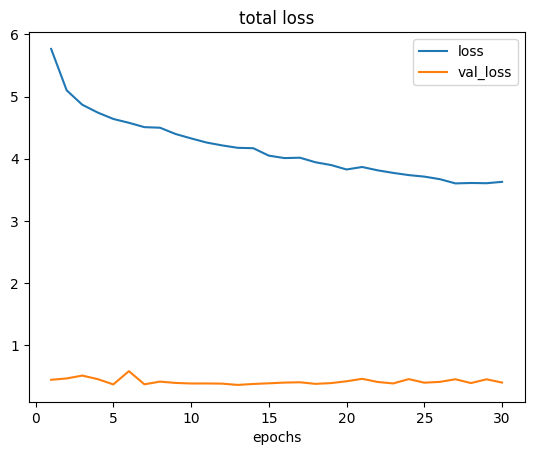

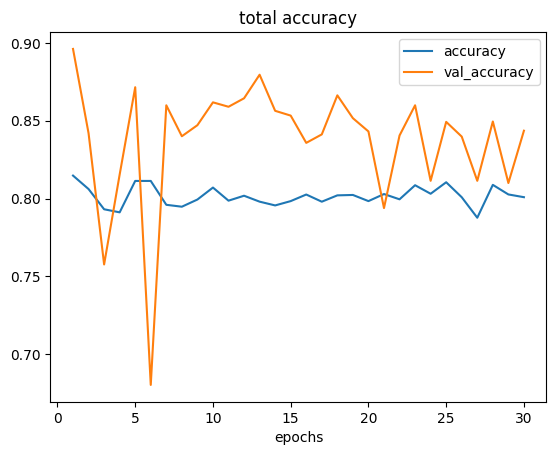

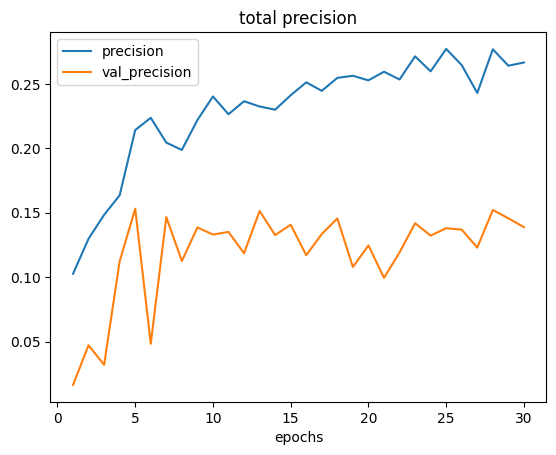

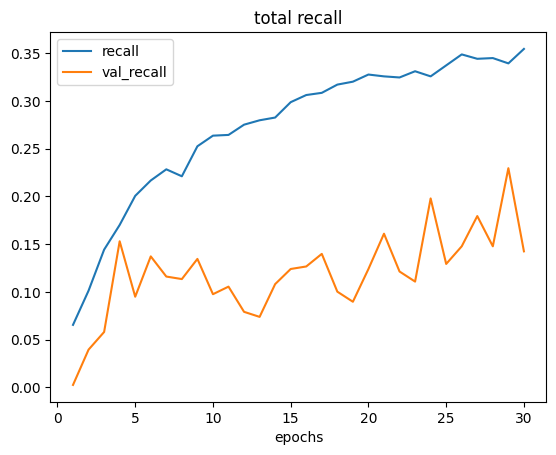

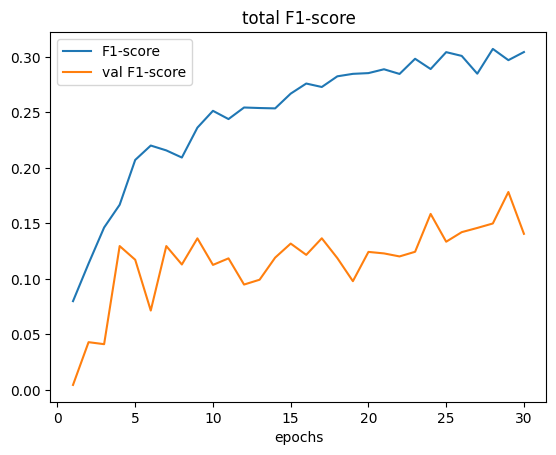

In [17]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

Epoch 1/30
664/664 [==============================] - 128s 192ms/step - loss: 3.5398 - accuracy: 0.8013 - precision: 0.2653 - recall: 0.3485 - f1_score: 0.3012 - val_loss: 0.4025 - val_accuracy: 0.8552 - val_precision: 0.1548 - val_recall: 0.1372 - val_f1_score: 0.1455
Epoch 2/30
664/664 [==============================] - 127s 192ms/step - loss: 3.5810 - accuracy: 0.7998 - precision: 0.2599 - recall: 0.3404 - f1_score: 0.2948 - val_loss: 0.4081 - val_accuracy: 0.8488 - val_precision: 0.1393 - val_recall: 0.1319 - val_f1_score: 0.1355
Epoch 3/30
664/664 [==============================] - 128s 193ms/step - loss: 3.5416 - accuracy: 0.8019 - precision: 0.2695 - recall: 0.3577 - f1_score: 0.3074 - val_loss: 0.4045 - val_accuracy: 0.8457 - val_precision: 0.1402 - val_recall: 0.1398 - val_f1_score: 0.1400
Epoch 4/30
664/664 [==============================] - 127s 191ms/step - loss: 3.4749 - accuracy: 0.8030 - precision: 0.2723 - recall: 0.3603 - f1_score: 0.3102 - val_loss: 0.4054 - val_accur

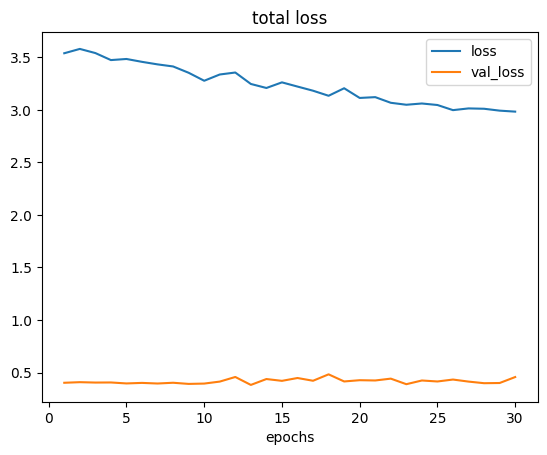

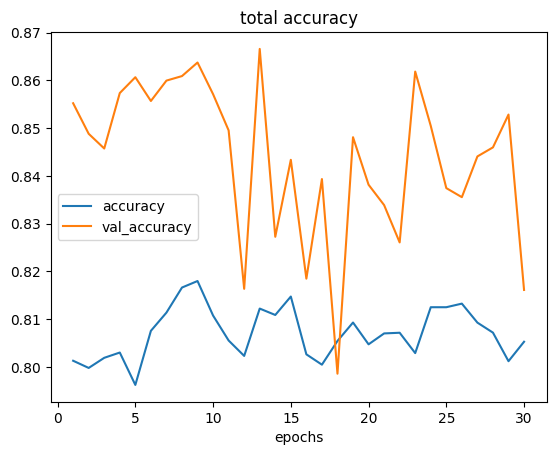

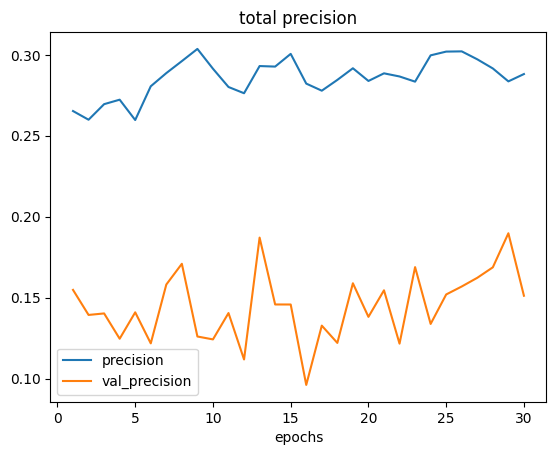

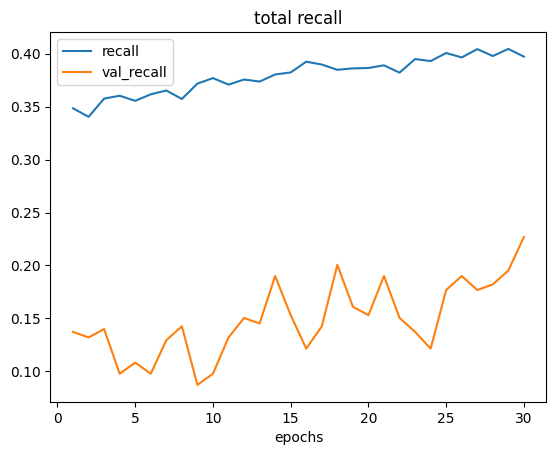

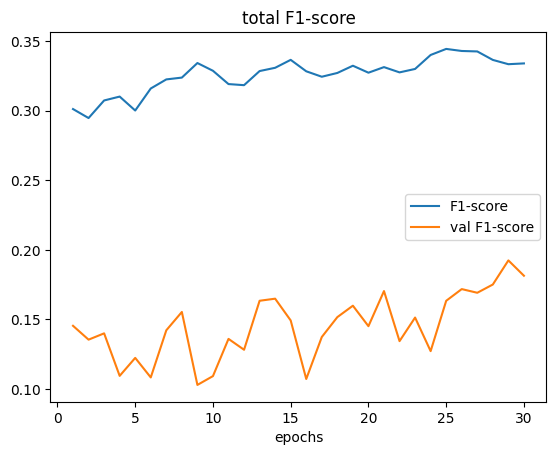

In [18]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

Epoch 1/30
664/664 [==============================] - 135s 203ms/step - loss: 2.9355 - accuracy: 0.8088 - precision: 0.2964 - recall: 0.4044 - f1_score: 0.3421 - val_loss: 0.4145 - val_accuracy: 0.8436 - val_precision: 0.1479 - val_recall: 0.1557 - val_f1_score: 0.1517
Epoch 2/30
664/664 [==============================] - 135s 203ms/step - loss: 2.8857 - accuracy: 0.8189 - precision: 0.3152 - recall: 0.4036 - f1_score: 0.3540 - val_loss: 0.4032 - val_accuracy: 0.8524 - val_precision: 0.1573 - val_recall: 0.1478 - val_f1_score: 0.1524
Epoch 3/30
664/664 [==============================] - 135s 203ms/step - loss: 2.8836 - accuracy: 0.8106 - precision: 0.3022 - recall: 0.4128 - f1_score: 0.3489 - val_loss: 0.4298 - val_accuracy: 0.8363 - val_precision: 0.1518 - val_recall: 0.1794 - val_f1_score: 0.1644
Epoch 4/30
664/664 [==============================] - 136s 204ms/step - loss: 2.8327 - accuracy: 0.8192 - precision: 0.3167 - recall: 0.4069 - f1_score: 0.3562 - val_loss: 0.4095 - val_accur

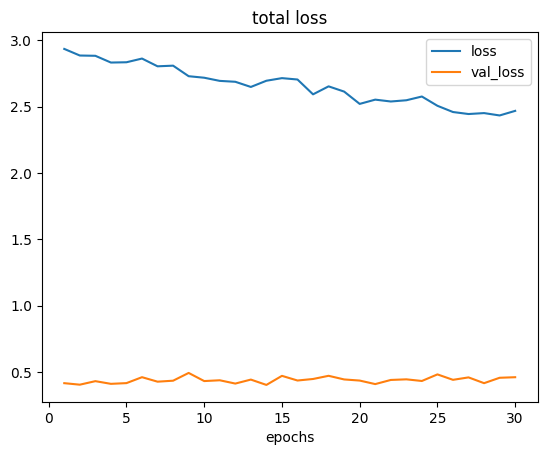

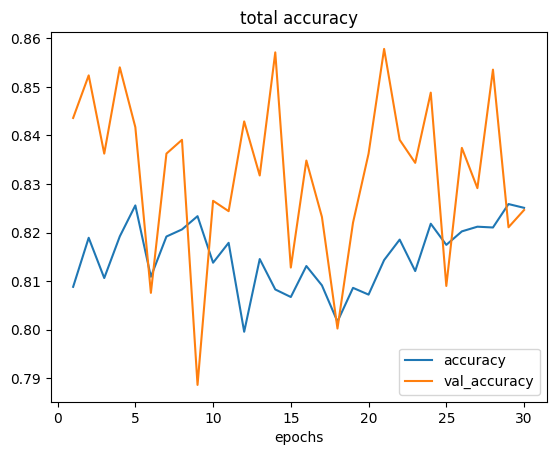

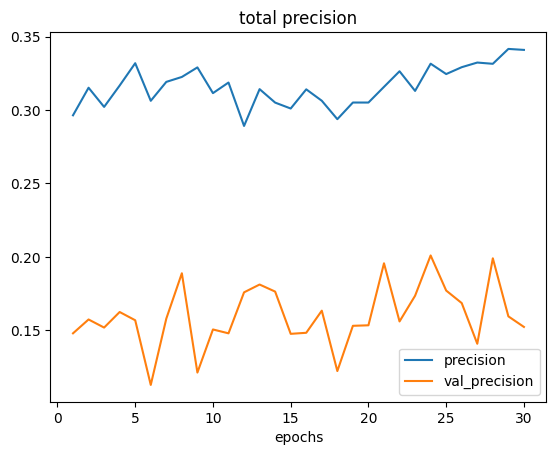

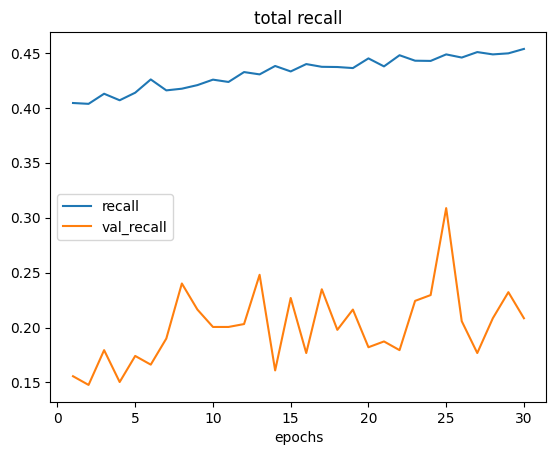

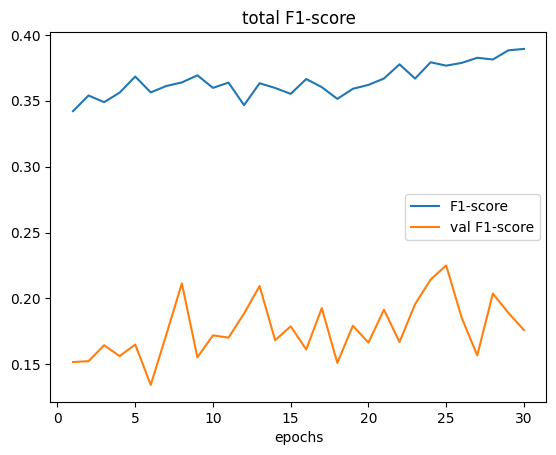

In [19]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

Epoch 1/30
664/664 [==============================] - 125s 188ms/step - loss: 2.3874 - accuracy: 0.8263 - precision: 0.3432 - recall: 0.4519 - f1_score: 0.3901 - val_loss: 0.4417 - val_accuracy: 0.8393 - val_precision: 0.1892 - val_recall: 0.2401 - val_f1_score: 0.2116
Epoch 2/30
664/664 [==============================] - 129s 194ms/step - loss: 2.4231 - accuracy: 0.8263 - precision: 0.3430 - recall: 0.4511 - f1_score: 0.3897 - val_loss: 0.4287 - val_accuracy: 0.8514 - val_precision: 0.1869 - val_recall: 0.1953 - val_f1_score: 0.1910
Epoch 3/30
664/664 [==============================] - 128s 192ms/step - loss: 2.2485 - accuracy: 0.8387 - precision: 0.3744 - recall: 0.4649 - f1_score: 0.4148 - val_loss: 0.4079 - val_accuracy: 0.8557 - val_precision: 0.1974 - val_recall: 0.1979 - val_f1_score: 0.1976
Epoch 4/30
664/664 [==============================] - 128s 193ms/step - loss: 2.3779 - accuracy: 0.8190 - precision: 0.3304 - recall: 0.4602 - f1_score: 0.3846 - val_loss: 0.4388 - val_accur

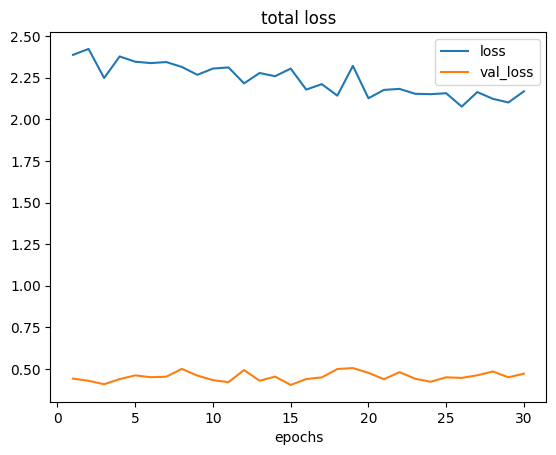

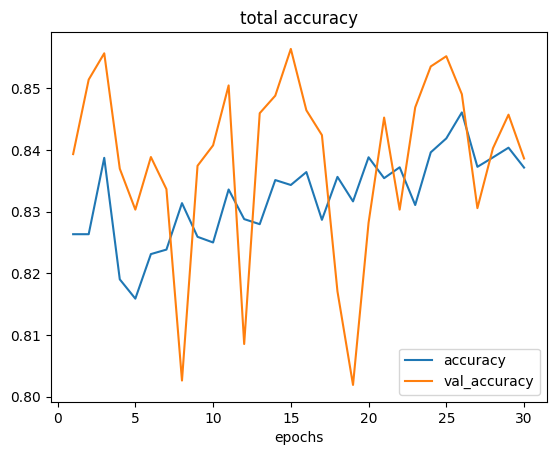

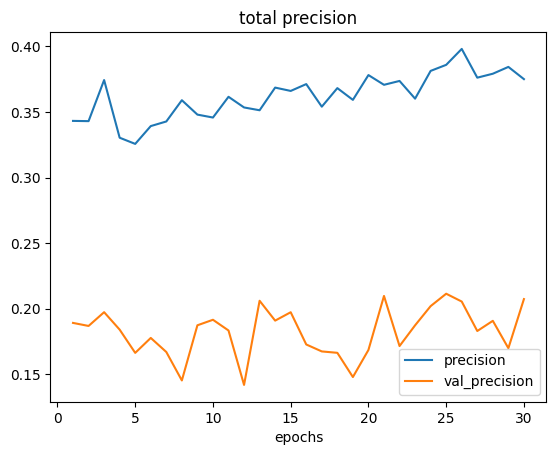

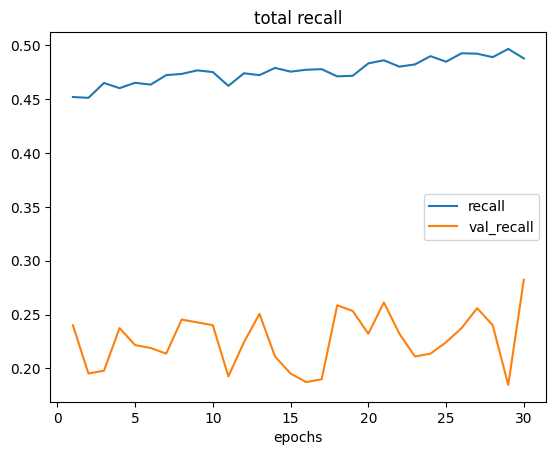

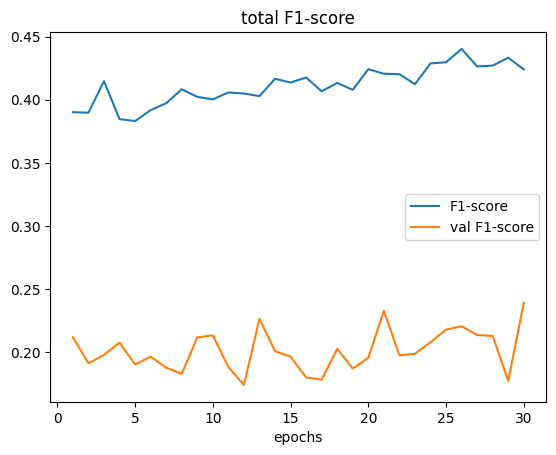

In [20]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

Epoch 1/30
664/664 [==============================] - 125s 187ms/step - loss: 2.0773 - accuracy: 0.8361 - precision: 0.3732 - recall: 0.4902 - f1_score: 0.4238 - val_loss: 0.4661 - val_accuracy: 0.8457 - val_precision: 0.2119 - val_recall: 0.2639 - val_f1_score: 0.2350
Epoch 2/30
664/664 [==============================] - 124s 187ms/step - loss: 2.0863 - accuracy: 0.8348 - precision: 0.3702 - recall: 0.4904 - f1_score: 0.4219 - val_loss: 0.4555 - val_accuracy: 0.8507 - val_precision: 0.1901 - val_recall: 0.2032 - val_f1_score: 0.1964
Epoch 3/30
664/664 [==============================] - 126s 189ms/step - loss: 2.0361 - accuracy: 0.8375 - precision: 0.3771 - recall: 0.4943 - f1_score: 0.4278 - val_loss: 0.5464 - val_accuracy: 0.8009 - val_precision: 0.1437 - val_recall: 0.2454 - val_f1_score: 0.1813
Epoch 4/30
664/664 [==============================] - 124s 186ms/step - loss: 2.0222 - accuracy: 0.8365 - precision: 0.3755 - recall: 0.4979 - f1_score: 0.4281 - val_loss: 0.4546 - val_accur

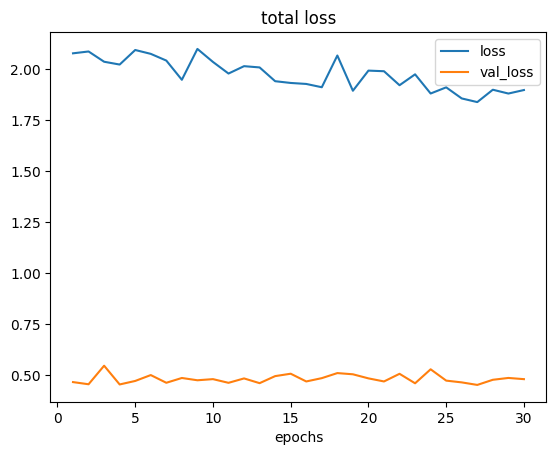

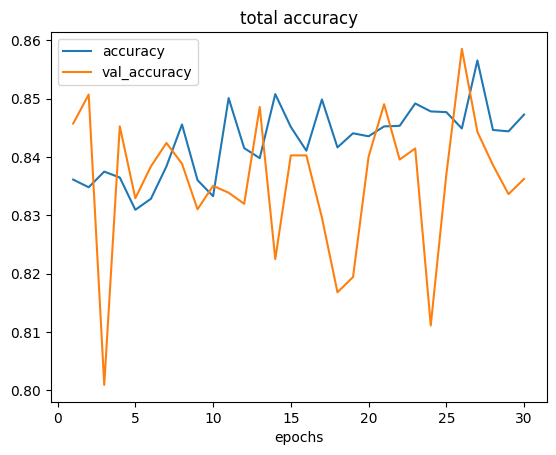

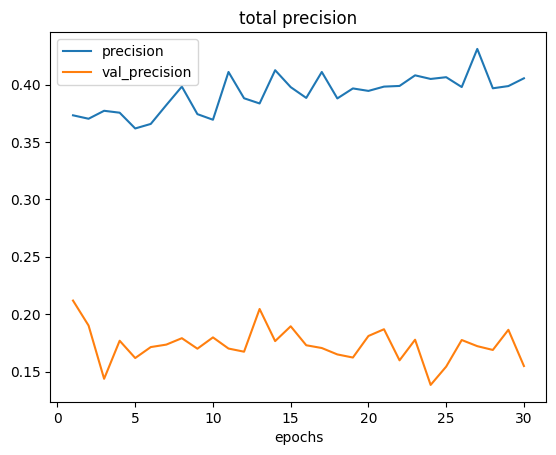

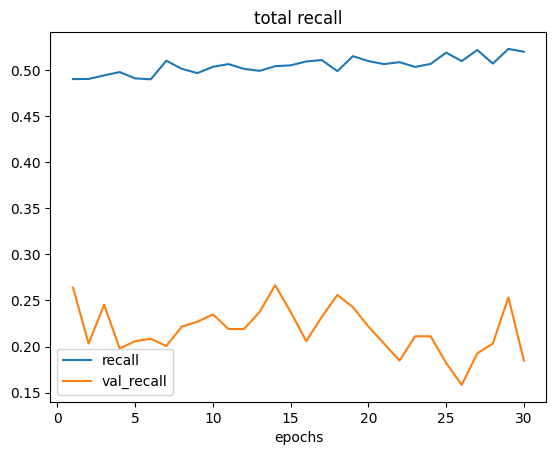

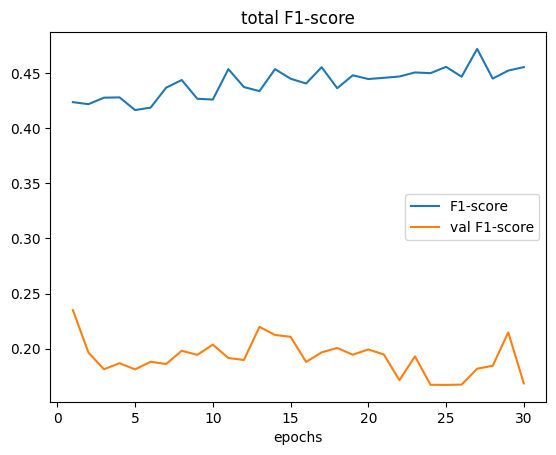

In [21]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

Epoch 1/30
664/664 [==============================] - 124s 186ms/step - loss: 1.8397 - accuracy: 0.8376 - precision: 0.3829 - recall: 0.5253 - f1_score: 0.4429 - val_loss: 0.4936 - val_accuracy: 0.8197 - val_precision: 0.1661 - val_recall: 0.2507 - val_f1_score: 0.1998
Epoch 2/30
664/664 [==============================] - 123s 186ms/step - loss: 1.8335 - accuracy: 0.8463 - precision: 0.4041 - recall: 0.5274 - f1_score: 0.4576 - val_loss: 0.4714 - val_accuracy: 0.8393 - val_precision: 0.1812 - val_recall: 0.2243 - val_f1_score: 0.2005
Epoch 3/30
664/664 [==============================] - 123s 186ms/step - loss: 1.8559 - accuracy: 0.8454 - precision: 0.4015 - recall: 0.5247 - f1_score: 0.4549 - val_loss: 0.4703 - val_accuracy: 0.8391 - val_precision: 0.1822 - val_recall: 0.2269 - val_f1_score: 0.2021
Epoch 4/30
664/664 [==============================] - 123s 185ms/step - loss: 1.8900 - accuracy: 0.8448 - precision: 0.3993 - recall: 0.5205 - f1_score: 0.4519 - val_loss: 0.4974 - val_accur

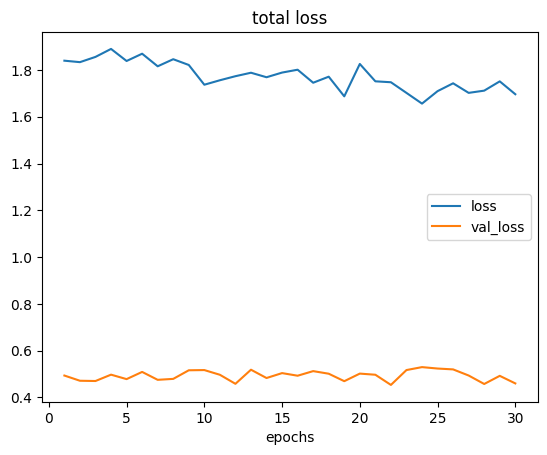

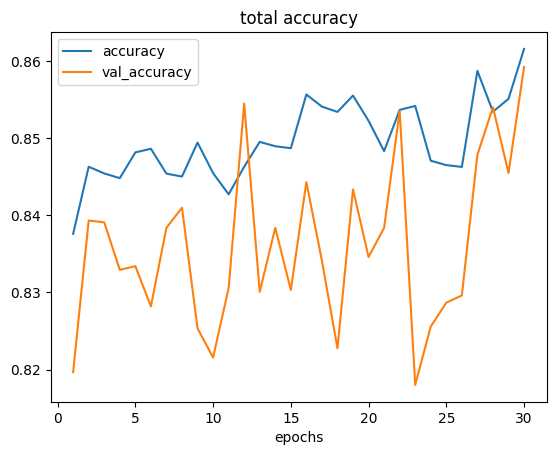

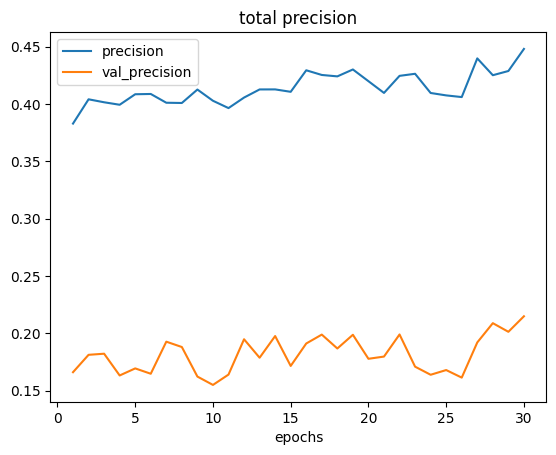

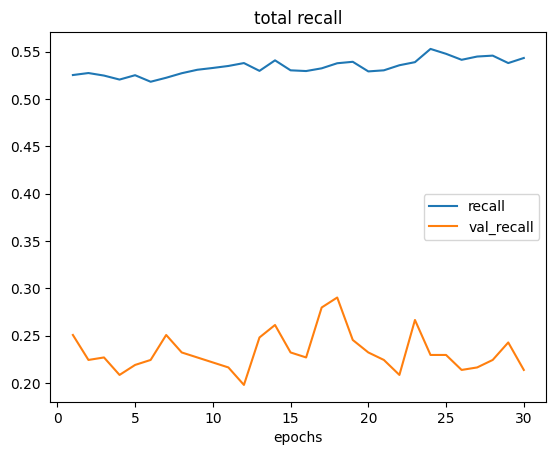

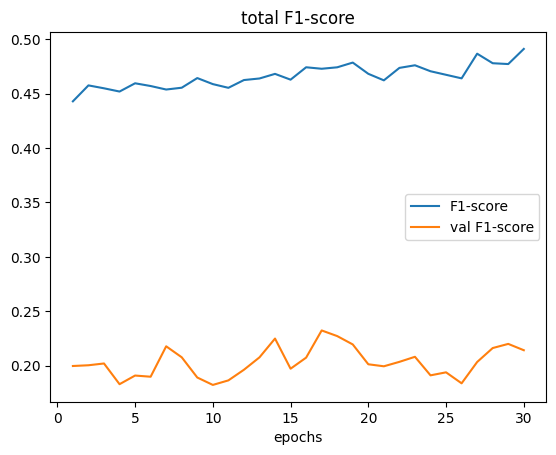

In [22]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1,
                    callbacks=[f1_callback, step_callback, tensorboard_callback])

draw_training_statistic(history)

In [23]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, class_labels, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix of a classification model.

    Args:
        y_true (numpy.ndarray): The ground truth labels.
        y_pred (numpy.ndarray): The predicted labels.
        classes (list): The list of class labels.
        class_labels: The list of class names.
        normalize (bool, optional): Whether to normalize the confusion matrix. Defaults to False.
        title (str, optional): The title of the plot. Defaults to None.
        cmap (matplotlib.colors.Colormap, optional): The colormap to use for the plot. Defaults to plt.cm.Blues.
    """

    cm = confusion_matrix(y_true, y_pred, labels=classes)

    if normalize:
        cm = confusion_matrix(y_true, y_pred, labels=classes).astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(title)
    fig.colorbar(im)

    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            ij = float(cm[i, j])
            ax.text(j, i, f"{ij:.2f}", ha='center', va='center', color='white' if ij > thresh else 'black')

    plt.tight_layout()
    plt.show()

# TRAINED MODEL (after 180 epochs)

In [24]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = y_test
y_train_nums = y_train

664/664 [==============================] - 33s 49ms/step


Test accuracy: 0.7395734597156398


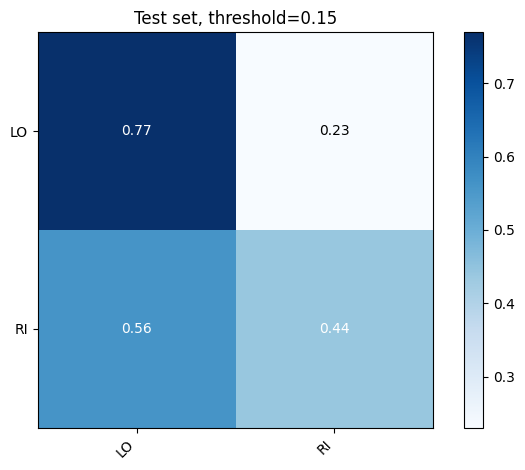

Train accuracy: 0.7929077680190256


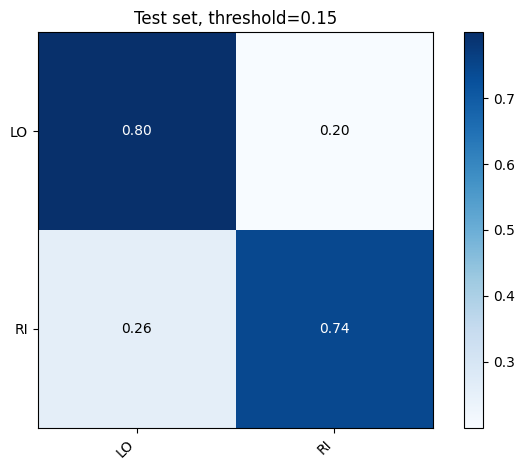

In [25]:
THRESHOLD = 0.15

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.8


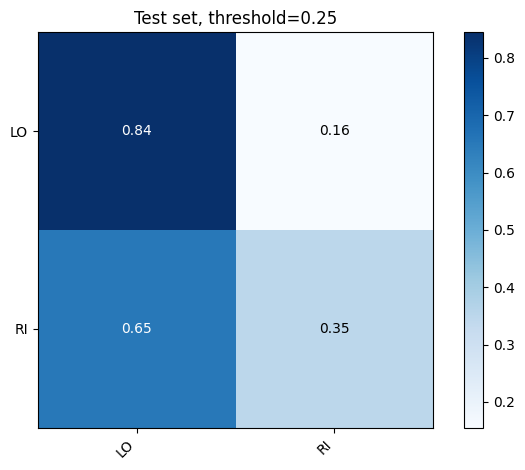

Train accuracy: 0.8465939862017


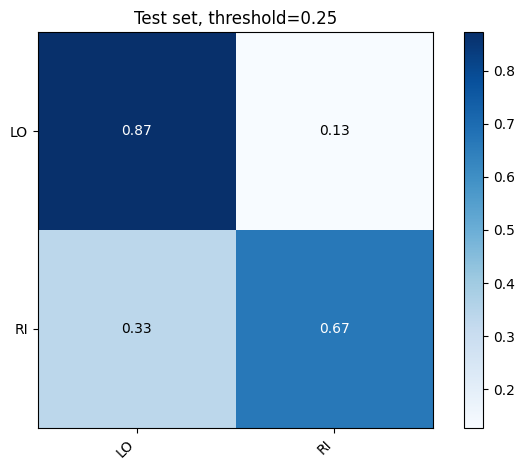

In [26]:
THRESHOLD = 0.25

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.8329383886255924


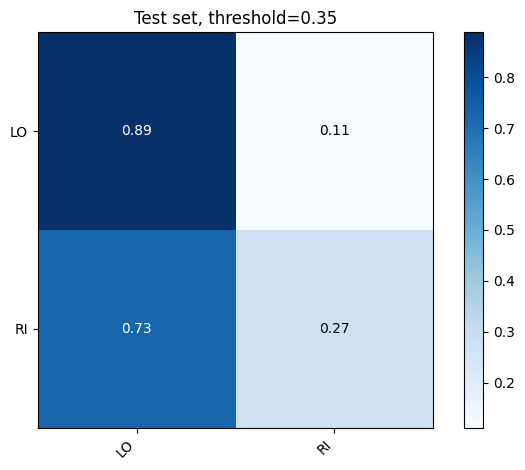

Train accuracy: 0.8770397230921378


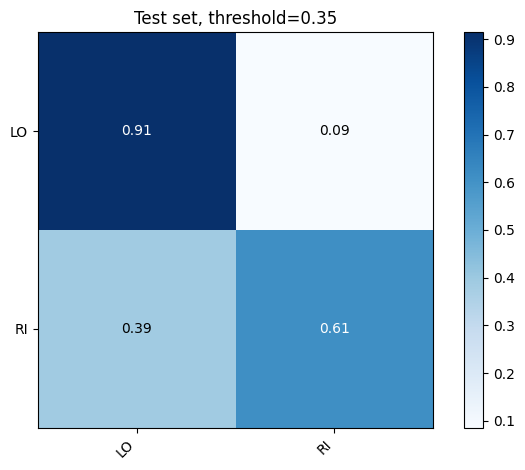

In [27]:
THRESHOLD = 0.35

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.8592417061611375


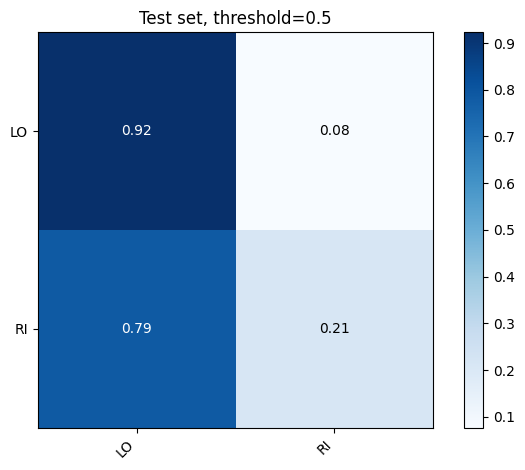

Train accuracy: 0.9003979373189857


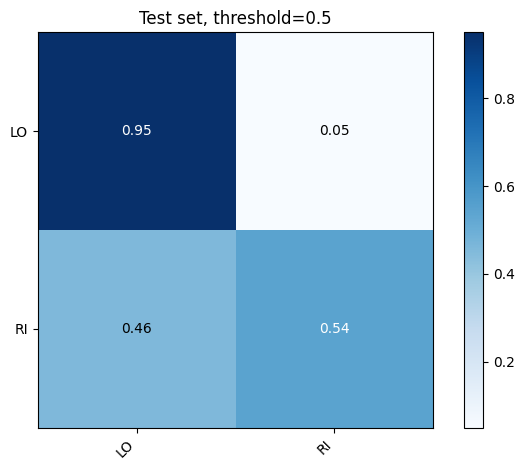

In [28]:
THRESHOLD = 0.5

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True, title=f"Test set, threshold={THRESHOLD}")

# Best validation F1-score model

In [29]:
# load the model
from transformers import TFBertModel

with open("./fine_models/model_ri.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={"TFBertModel": TFBertModel})
model.load_weights('./fine_models/model_ri_best_f1_red_weighted_v6.h5')

In [30]:
y_test_pred = model.predict(test_dataset)
y_train_pred = model.predict(train_dataset)

y_test_nums = y_test
y_train_nums = y_train

664/664 [==============================] - 34s 50ms/step


Test accuracy: 0.6597156398104266


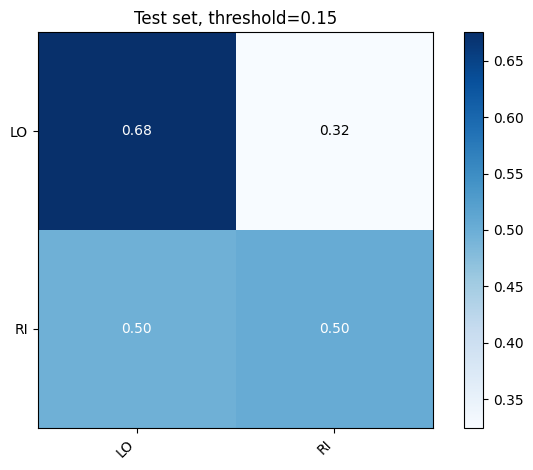

Train accuracy: 0.7184534601709482


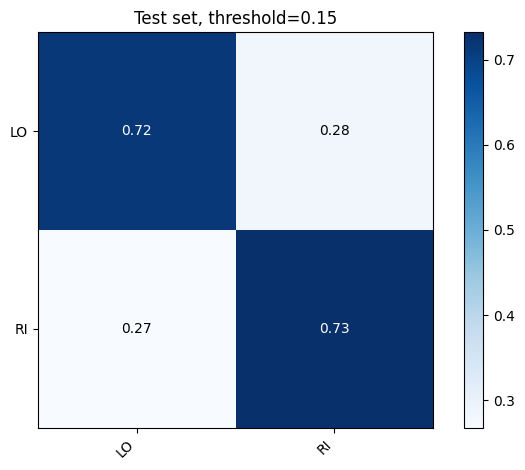

In [31]:
THRESHOLD = 0.15

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.7447867298578199


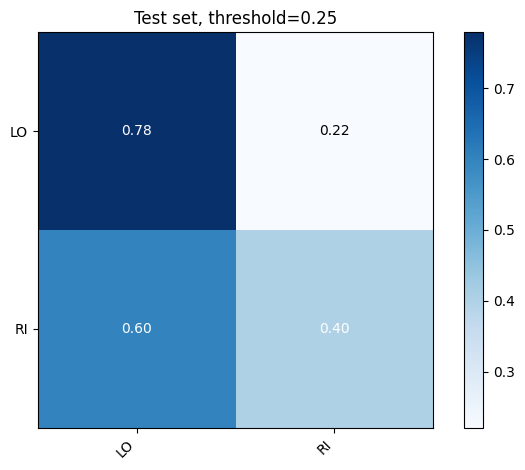

Train accuracy: 0.7926487555628812


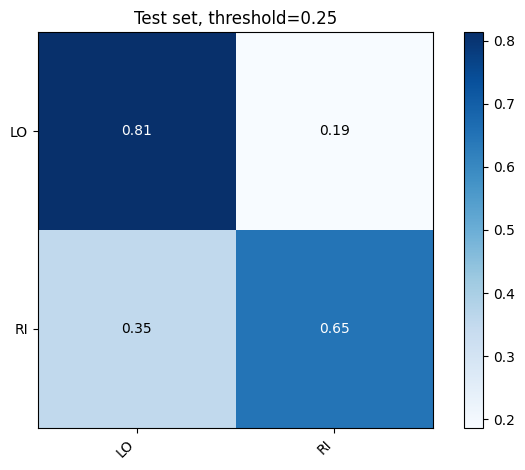

In [32]:
THRESHOLD = 0.25

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.7928909952606635


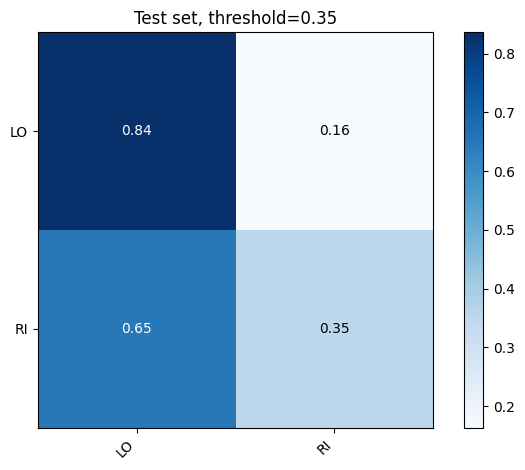

Train accuracy: 0.8352209847182651


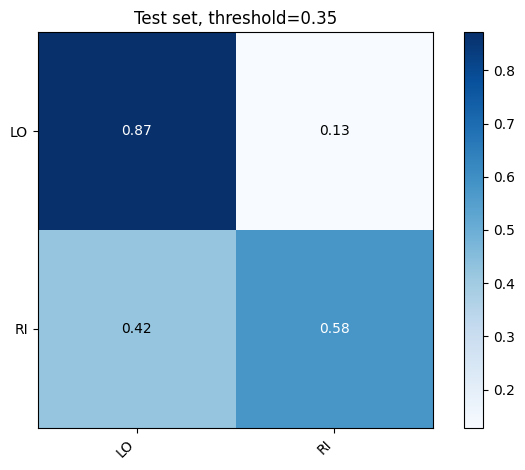

In [33]:
THRESHOLD = 0.35

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

Test accuracy: 0.8386255924170616


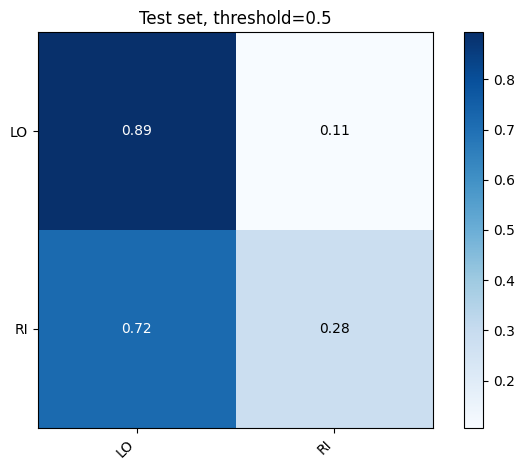

Train accuracy: 0.8714591819915704


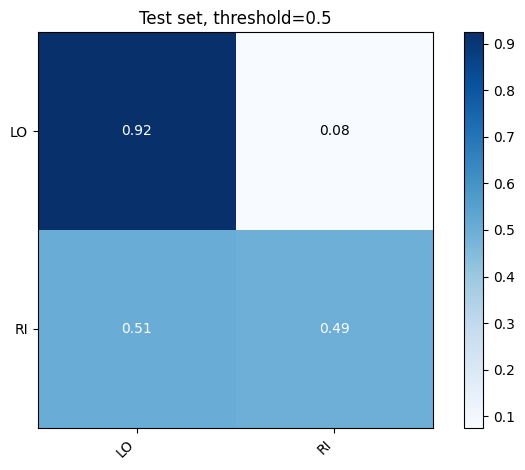

In [34]:
THRESHOLD = 0.5

y_test_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_test_pred]
y_train_pred_nums = [0 if x_ < THRESHOLD else 1 for x_ in y_train_pred]

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1], class_labels=["LO", "RI"], normalize=True,
                      title=f"Test set, threshold={THRESHOLD}")